In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import transforms, io
from tqdm import tqdm
from matplotlib import pyplot as plt

from room_rate.data.dataset import RatedImageDataset
from room_rate import models, lib

In [2]:
def im_norm(im):
    """
    Convert image from 0 to 255 (int) to -1 to 1 (float)
    """
    return (im.float()/128 - 1).float()

#Add in some minimal data augmentation for training, 
#since dataset is limited and we'll want to train multiple epochs
augment = transforms.Compose([
    transforms.RandomAffine([-15,15], translate=(0,.05), scale=(.9,1.1)),
    transforms.RandomHorizontalFlip(),
    lib.im_norm,
])

In [3]:
data_dir = '../data/rated_images_no0/'
#CHANGE transform to augment to use image agumentation!
#Currently off because only training 1 epoch
train = RatedImageDataset(data_dir + 'train/', transform=lib.im_norm) #Apply augmentation in training
test = RatedImageDataset(data_dir + 'test/', transform=lib.im_norm) #Not in testing

In [4]:
batch_size = 8
train_loader = DataLoader(train, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

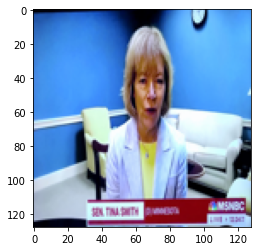

In [5]:
#Show an example [agumented] image
#Normalization is undone for viewing
plt.imshow((next(iter(train_loader))[0][0].permute(1,2,0))/2 + .5)

#### Config

In [11]:
use_pretrained = True
feature_extract = False
lr = 1e-3
epochs = 1
#regression vs. classification:
num_classes = 1
criterion = nn.MSELoss()
# num_classes = 11
# criterion = nn.CrossEntropyLoss()

In [17]:
net = models.get_resnet(num_classes=1,
                        feature_extract=feature_extract,
                        use_pretrained=use_pretrained,
                       )

train_losses = []
test_losses = []

In [18]:
optimizer = optim.SGD(net.parameters(), lr=lr)

In [34]:
# nr = 100

for epoch in range(epochs):  # loop over the dataset multiple times
    #Train:
    running_loss = 0.0
    net.train()
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        if isinstance(criterion, nn.MSELoss):
            labels = labels.float()
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()
    running_loss = running_loss/len(train_loader)
    print('train_loss: ' + str(running_loss))
    train_losses.append(running_loss)
    
    #Test
    running_loss = 0.0
    net.eval()
    for images, labels in tqdm(test_loader):
        out = net(images)
        if isinstance(criterion, nn.MSELoss):
            labels = labels.float()
        loss = criterion(out.squeeze(), labels)
        running_loss = running_loss + loss.item()
    running_loss = running_loss/len(test_loader)
    test_losses.append(running_loss)
    print('test_loss: ' + str(running_loss))

print('Finished Training')

100%|██████████| 283/283 [05:38<00:00,  1.19s/it]


train_loss: 1.0051266028687305


100%|██████████| 94/94 [00:34<00:00,  2.69it/s]

test_loss: 2.014714098674186
Finished Training


Plot losses over epochs (not really useful for 1 epoch)

Text(0.5, 0, 'Epoch')

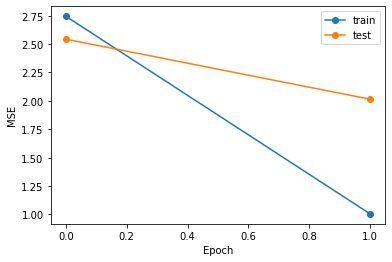

In [42]:
plt.plot(train_losses, 'o-', label='train')
plt.plot(test_losses, 'o-', label='test')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epoch')

Calculate predictions on test set (and save actual test set ratings)

In [36]:
labell = []
resultl = []
for images, labels in tqdm(test_loader):
    out = net(images)
    if isinstance(criterion, nn.CrossEntropyLoss):
        resultl.append(list(torch.argmax(out.detach(), dim =1)))
    else:
        resultl.append(list(out.detach()))
    labell.append(list(labels))

r = torch.tensor(resultl).flatten()
l = torch.tensor(labell).flatten()

100%|██████████| 94/94 [00:39<00:00,  2.40it/s]


Quick way to view data: scatter plot

Text(0, 0.5, 'Predicted Rating')

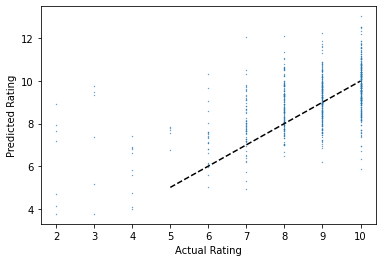

In [37]:
plt.scatter(labell, resultl, s = .1)
plt.plot([5,10], [5, 10], 'k--')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

Group data by actual rating

In [38]:
rate_range = range(1, 11)
rdict = {val: [] for val in rate_range}

for i,label in enumerate(l):
    rdict[label.item()].append(r[i].item())

So we can get average/std for each actual rating

In [39]:
means = [torch.tensor(rdict[i]).float().mean() for i in rate_range]
stds = [torch.tensor(rdict[i]).float().var().sqrt() for i in rate_range]

In [40]:
#name to use saving images and weights
expname = 'MSE_Resnet18_Pretrained_noFeatureExtract_noAugment_1Epoch_LR1e-3'

Text(0.5, 1.0, 'Predicted vs. Actual Ratings on Test Set')

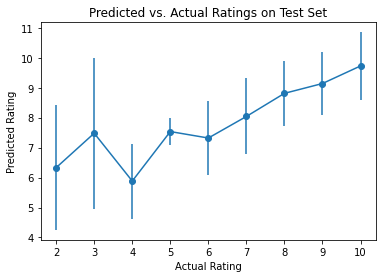

In [41]:
plt.errorbar(rate_range, means, stds, fmt = 'o-')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs. Actual Ratings on Test Set')
# plt.savefig(f'../imgs/{expname}.png')
# plt.plot([5,10], [5, 10], 'k--')

In [28]:
# torch.save(net.state_dict(), f'../models/{expname}.pt')

In [29]:
num_samples = [len(val) for key,val in rdict.items()]

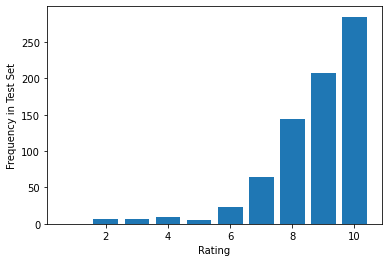

In [30]:
plt.bar(rate_range, num_samples)
plt.xlabel('Rating')
plt.ylabel('Frequency in Test Set')
plt.savefig(f'../imgs/test_rate_freq.png')

In [31]:
train_labels =[rate for img,rate in train]

In [32]:
rate_range = range(1, 11)
tdict = {val: 0 for val in rate_range}

for i,label in enumerate(train_labels):
    tdict[label] += 1

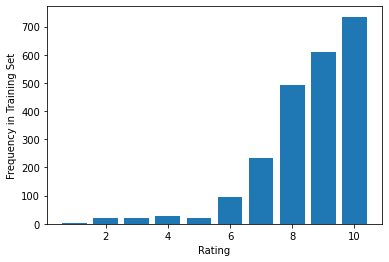

In [33]:
train_freqs = [val for key,val in tdict.items()]
plt.bar(rate_range, train_freqs)
plt.xlabel('Rating')
plt.ylabel('Frequency in Training Set')
plt.savefig(f'../imgs/train_rate_freq.png')